In [3]:
Float = Float64; # Define datatype to be used for all operations

In [4]:
using MLUtils, MLDataUtils, MLDatasets, Images, Augmentor, Flux, ProgressMeter, Plots, BenchmarkTools
using Printf
using BSON: @save, @load
using SymPy
using Base.Iterators

ProgressMeter.ijulia_behavior(:clear)

┌ Info: Precompiling SymPy [24249f21-da20-56a4-8eb1-6a02cf4ae2e6]
└ @ Base loading.jl:1664


false

# Load Dataset

In [3]:
xtrain, ytrain = FashionMNIST(split=:train)[:]
xtest, ytest = FashionMNIST(split=:test)[:]
xtrain = Float.(xtrain)
xtest = Float.(xtest)
summary(xtrain), summary(xtest)

("28×28×60000 Array{Float64, 3}", "28×28×10000 Array{Float64, 3}")

In [4]:
# Transform labels to One of K coding
Ytrain = convertlabel(LabelEnc.OneOfK{Float}, ytrain, 0:9)
Ytest = convertlabel(LabelEnc.OneOfK{Float}, ytest, 0:9)
summary(Ytrain), summary(Ytest)

("10×60000 Matrix{Float64}", "10×10000 Matrix{Float64}")

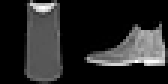

In [5]:
# Flip images (because Julia uses column major order) and bring to the correct number of dimensions
Xtrain = Float.(reshape(permutedims(xtrain, (2,1,3)), 28, 28, 1, :));
Xtest = Float.(reshape(permutedims(xtest, (2,1,3)), 28, 28, 1, :));
colorview(Gray, [Xtrain[:,:,1,3] Xtest[:,:,1,1]])

# Set up Data Augmentation

In [6]:
augmentpipeline = Rotate(LinRange(-25,25,10)) |>
    Zoom(0.8:0.05:1.2) |> 
    ShearX(-20:20) |> 
    ShearY(-20:20) |> 
    #ElasticDistortion(5) |> 
    CropSize(28,28)

5-step Augmentor.ImmutablePipeline:
 1.) Rotate by θ ∈ LinRange{Float64}(-25.0, 25.0, 10) degree
 2.) Zoom by I ∈ {0.8×0.8, 0.85×0.85, 0.9×0.9, 0.95×0.95, 1.0×1.0, 1.05×1.05, 1.1×1.1, 1.15×1.15, 1.2×1.2}
 3.) ShearX by ϕ ∈ -20:20 degree
 4.) ShearY by ψ ∈ -20:20 degree
 5.) Crop a 28×28 window around the center

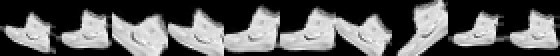

In [7]:
# Test Data Augmentation
testaugment = hcat((augment(Xtrain[:,:,1,1], augmentpipeline) for _ in 1:10)...)
colorview(Gray, testaugment)

In [8]:
function augment_batch(batch, augmentpipeline)
    src = batch[:,:,1,:]
    dst = similar(src)
    augmentbatch!(dst, src, augmentpipeline, ObsDim.Last())
    return reshape(dst, 28, 28, 1, :)
end

augment_batch (generic function with 1 method)

# Create the Neural Network Model

#### Define closed-form versions of activation functions

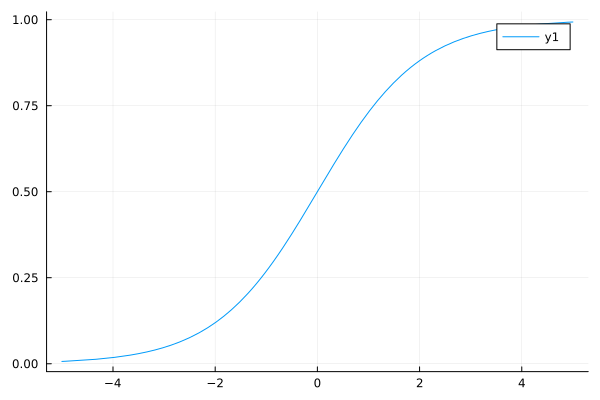

In [9]:
slow_sigmoid(x::Number) = 1 ./ (1 .+ exp.(.-x))
plot(slow_sigmoid)

#### Define the network architecture

In [36]:
model = Chain(
  Dense(28 * 28, 32, slow_sigmoid),       
  Dense(32, 16, slow_sigmoid),          
  Dense(16, 10, slow_sigmoid),              
)
model

Chain(
  Dense(784 => 32, slow_sigmoid),       # 25_120 parameters
  Dense(32 => 16, slow_sigmoid),        # 528 parameters
  Dense(16 => 10, slow_sigmoid),        # 170 parameters
)                   # Total: 6 arrays, 25_818 parameters, 101.227 KiB.

#### Define the loss function and an accuracy measure for evaluation

In [ ]:
loss(x, y) = Flux.Losses.logitcrossentropy(model(Flux.flatten(x)), y)
accuracy(x,y) = sum(y' .== [c.I[1]-1 for c in argmax(model(Flux.flatten(x)), dims=1)])/length(y)

# Train Neural Network

In [10]:
function train_batch(x, y, loss, opt, params, epochs; batchsize=1024)
    gpu_Xtest = Xtest # gpu here is a misnomer since for networks that small, training on a GPU does not make sense
    gpu_Ytest = Ytest
    gpu_ytest = ytest
    gpu_train_Xtest = x[:,:,:, 1:512]
    gpu_train_Ytest = y[:, 1:512]
    p = Progress(epochs, showspeed=true)
    for epoch in 1:epochs
        data = MLUtils.eachobs(MLUtils.shuffleobs((x, y)), batchsize=batchsize)
        for batch in data
            x_ = augment_batch(batch[1], augmentpipeline)
            y_ = batch[2]
            batch = (batch[1], batch[2])
            Flux.train!(loss, params, [batch], opt)
        end
        trainloss = loss(gpu_train_Xtest, gpu_train_Ytest)
        testloss = loss(gpu_Xtest, gpu_Ytest)
        testaccuracy = accuracy(gpu_Xtest, ytest)
        ProgressMeter.next!(p; showvalues = [(:testloss, testloss), (:testaccuracy, testaccuracy), (:trainloss, trainloss)])
    end
end

train_batch (generic function with 1 method)

In [ ]:
train_batch(Xtrain, Ytrain, loss, Flux.Optimise.Optimiser(Flux.Optimise.ClipValue(1e-3), RAdam(0.001)), Flux.params(model), 150; batchsize=128)

### Save and/or Load the model so we don't have to train every time again

In [75]:
@save "fashionMNIST_small_dense_acc86.bson" model

In [10]:
@load "fashionMNIST_small_dense_acc86.bson" model
model

Chain(
  Dense(784 => 32, slow_sigmoid),       # 25_120 parameters
  Dense(32 => 16, slow_sigmoid),        # 528 parameters
  Dense(16 => 10, slow_sigmoid),        # 170 parameters
)                   # Total: 6 arrays, 25_818 parameters, 101.227 KiB.

# Define Record Type for Formula Extraction

We now define a data type that we will send through the network instead of a floating point number. The new data type wraps another data type (e.g. a float) but also records everything that happens to it and generates a formula for the value that it wraps while it is manipulated.

We can then send a matrix of instances of this data type through the network and the output values will not only be the correct neuron outputs, but also a formula of how we got to this result.

More info can be found in the white paper.

In [5]:
"""
Recursively joins strings and Arrays of String
"""
function joinrecurse(a)
    if typeof(a) <: AbstractString
        return a
    end
    return join([joinrecurse(i) for i in a])
end

joinrecurse

In [6]:
struct RecordFormula{T<:Real} <: Number
    val::T
    formula::Vector{Any}
end

RecordFormula(v::T, f::S) where{T<:Real, S} = RecordFormula{T}(v, f)
RecordFormula{S}(v::T) where {S, T<:Real} = RecordFormula{S}(S(v), [string(v)])
RecordFormula(v::T) where {T<:Real} = RecordFormula{T}(v, [string(v)])
RecordFormula(v::Bool) = RecordFormula{Int}(Int(v))
val(r::RecordFormula) = r.val
formula(r::RecordFormula) = joinrecurse(r.formula)
Base.Pair(r::RecordFormula) = Pair(formula(r)=>val(r))

Base.similar(a::Array{T}, m::Int) where {T<:RecordFormula} = zeros(T, m)
Base.similar(a::AbstractArray{T}, dims::Base.DimOrInd...) where {T<:RecordFormula} = zeros(T, Base.to_shape(dims))
Base.similar(a::Array{T}, dims::Dims{N}) where {T<:RecordFormula,N} = zeros(T, dims)
Base.similar(a::AbstractArray, ::Type{T}, dims::Base.DimOrInd...) where {T<:RecordFormula} = zeros(T, Base.to_shape(dims))

Base.typemin(t::Type{RecordFormula{T}}) where {T} = typemin(T)
Base.typemin(x::RecordFormula{T}) where {T} = typemin(T)

Base.convert(::Type{RecordFormula{T}}, v::T) where {T} = RecordFormula{T}(v, [string(v)])
Base.convert(::Type{RecordFormula{S}}, v::RecordFormula{T}) where {S, T} = RecordFormula{S}(S(val(v)), v.formula)
Base.convert(::Type{RecordFormula{T}}, x::Number) where {T} = RecordFormula(x)
Base.promote_rule(::Type, ::Type{RecordFormula{T}}) where {T} = RecordFormula{T}
Base.promote_rule(::Type{RecordFormula{S}}, ::Type{RecordFormula{T}}) where {S,T} = RecordFormula{promote_type(S,T)}
Base.promote_rule(::Type{Bool}, ::Type{RecordFormula{T}}) where {T} = RecordFormula{T}

Base.:(==)(a::RecordFormula, b::RecordFormula) = val(a) == val(b)

recordtostring(r::RecordFormula) = formula(r)*";"*@sprintf("%.20g", val(r))

recordtostring (generic function with 1 method)

In [7]:
for op in [:*, :+, :-, :/]
    @eval begin
        function Base.$op(a::RecordFormula, b::RecordFormula)
            str = ["(", a.formula, string($op), b.formula, ")"]
            newval = $op(a.val, b.val)
            
            return RecordFormula(newval, str)
        end
    end
end

for op in [:sin, :cos, :tan, :tanh, :log, :exp, :-, :abs]
    @eval begin
        function Base.$op(a::RecordFormula)
            str = [string($op), "(", a.formula, ")"]
            newval = $op(a.val)
            
            return RecordFormula(newval, str)
        end
    end
end

In [9]:
function Base.max(a::RecordFormula, b::RecordFormula)
    v = max(val(a), val(b))
    return RecordFormula(v, ["(",formula(a)," max ", formula(b),")"])
end

Base.max(a::Real, b::RecordFormula) = max(RecordFormula(a), b)

### Define functions to wrap elements of tensors/arrays into RecordFormulas to be passed through a neural network

In [16]:
function recordify(a::Array{T, 1}, name::String) where T
    res = Array{RecordFormula, 1}(size(a))
    for r in 1:size(a, 1)
        res[r] = RecordFormula(a[r], ["$(name)_$(r)_"])
    end
    return res
end

recordify (generic function with 1 method)

In [17]:
function recordify(a::Array{T, 2}, name::String) where T
    res = Array{RecordFormula, 2}(size(a))
    for c in 1:size(a, 2)
        for r in 1:size(a, 1)
            res[r,c] = RecordFormula(a[r,c], ["$(name)_$(r)_$(c)_"])
        end
    end
    return res
end

recordify (generic function with 2 methods)

In [18]:
function recordify(a::Array{T, 3}, name::String) where T
    res = Array{RecordFormula, 3}(size(a))
    for k in 1:size(a, 3), j in 1:size(a, 2), i in 1:size(a, 1)
        res[i,j,k] = RecordFormula(a[i,j,k], ["$(name)_$(i)_$(j)_$(k)_"])
    end
    return res
end

recordify (generic function with 3 methods)

In [19]:
function recordify(a::Array{T, 4}, name::String) where T
    res = Array{RecordFormula, 4}(size(a))
    for l in 1:size(a, 4), k in 1:size(a, 3), j in 1:size(a, 2), i in 1:size(a, 1)
        res[i,j,k,l] = RecordFormula(a[i,j,k,l], ["$(name)_$(i)_$(j)_$(k)_$(l)_"])
    end
    return res
end

recordify (generic function with 4 methods)

# Extract Formulas
Define functions and helper functions to extract layerwise formulas from a neural networks

In [20]:
"""Given the output of a layer, returns formulas for all the outputs and a new array where the formulas are replaced by intermediate variabels"""
function generate_layer_formula(layer_out, layer_prefix)
    res = copy(layer_out)
    v = @view res[:]
    formulas = []
    for i in 1:length(v)
        var_name = "$(layer_prefix)_$i"
        f = formula(v[i])
        push!(formulas, "$var_name=$f")
        v[i] = RecordFormula(val(v[i]), ["$(layer_prefix)_$i"])
    end
        
    return formulas, res
end

generate_layer_formula

In [21]:
"""Given an input image, creates an input with input variable placeholders to create formulas"""
function generate_input(img)
    o = map(x->RecordFormula(x[2], ["in_$(x[1])"]), enumerate(img))
    return o
end

generate_input

In [22]:
"""Given a model and an input, returns all formulas for all the layers of it"""
function formalize_model(model, input)
    input = Flux.flatten(input)
    all_formulas = []
    max_layers = length(model)
    @showprogress for (i, layer) in enumerate(model)
        model_out = layer(input)
        layer_output_name = i == max_layers ? "out" : "l$i" 
        formulas, input = generate_layer_formula(model_out, layer_output_name)
        push!(all_formulas, formulas)
    end
    return all_formulas
end

formalize_model

In [23]:
"""Given an image, converts it to input assignments for the formulas and expected outputs, used for testing"""
function convert_image(img, model)
    img = Flux.flatten(img)
    input = ["in_$i=$val" for (i, val) in enumerate(vec(img[:,:,:,:]))]
    model_output = model(img)
    output = ["out_$i=$val" for (i, val) in enumerate(vec(model_output))]
    return input, output
end

convert_image

In [24]:
# Generate formulas for the newtork using an arbitrary image as a dummy for input conversion
all_formulas = formalize_model(model, generate_input(Xtrain[:,:,:,1:1]));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


### Code to check the correctness of the generated formulas

In [25]:
"""Given one formula and variable assignments, returns assignment for the output variable of the formula"""
function quick_eval_formula(formula)
    variable, formula = split(formula, "=")
    res = eval(Meta.parse(String(formula)))
    return "$variable=$res"
end

function eval_variables(variables)
    for v in variables
        eval(Meta.parse(v))
    end
end

"""Given one formula and variable assignments, returns assignment for the output variable of the formula"""
function quick_eval_formula(formula, input)
    eval_variables(input)
    quick_eval_formula(formula)
end

"""Evaluates all results from formulas generated from a neural network"""
function quick_eval_formulas(all_formulas, input)
    results = []
    for layer in all_formulas
        eval_variables(input)
        new_inpt = []
        @showprogress for formula in layer
            out = quick_eval_formula(formula)
            push!(new_inpt, out)
        end
        push!(results, new_inpt)
        input=new_inpt
    end
    return results
end

quick_eval_formulas

In [26]:
i, o = convert_image(Xtrain[:,:,:,1:1], model)

(["in_1=0.0", "in_2=0.0", "in_3=0.0", "in_4=0.0", "in_5=0.0", "in_6=0.0", "in_7=0.0", "in_8=0.0", "in_9=0.0", "in_10=0.0"  …  "in_775=0.0", "in_776=0.11372549086809158", "in_777=0.26274511218070984", "in_778=0.45098039507865906", "in_779=0.3607843220233917", "in_780=0.0", "in_781=0.0", "in_782=0.0", "in_783=0.0", "in_784=0.0"], ["out_1=7.195017215922993e-7", "out_2=1.3992065222262357e-8", "out_3=2.1722752647659776e-36", "out_4=2.1147685990010637e-9", "out_5=9.105949801740698e-30", "out_6=5.076764472763604e-5", "out_7=2.0398359679895836e-15", "out_8=5.836477275531755e-7", "out_9=1.804053291273806e-7", "out_10=0.9999997273455952"])

In [39]:
results = quick_eval_formulas(all_formulas, i)
for (res, expected) in zip(results[end], o)
    res = parse(Float32, split(res, "=")[end])
    expected = parse(Float32, split(expected, "=")[end])
    println("Difference formulas/direct model output: $(res-expected)")
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Difference formulas/direct model output: 1.1368684e-13
Difference formulas/direct model output: -1.7763568e-15
Difference formulas/direct model output: 3.59e-43
Difference formulas/direct model output: -8.881784e-16
Difference formulas/direct model output: -3.0092655e-36
Difference formulas/direct model output: 1.4551915e-11
Difference formulas/direct model output: 2.1175824e-22
Difference formulas/direct model output: 1.1368684e-13
Difference formulas/direct model output: 0.0
Difference formulas/direct model output: 0.0


### Generate output files for the network as required by Paceval
Docstrings are part of an email from Jörg, defining the required output format

In [117]:
"""
we create the files for all layers with the individual functions that provide
variable results (l1_1, l1_2, ..., l2_1, l2_2, ...), as well as the functions
for the outputs (out_1, out_2, ...) in the folder "formulas".
"""
function write_formulas(all_formulas, base_dir)
    formulas = Base.Iterators.flatten(all_formulas)|>collect
    for (varname, formula) in split.(formulas, "=")
        open(joinpath(base_dir, varname*".txt"), "w") do io
            println(io, formula)
        end
    end
end

write_formulas

In [47]:
"""
we create the file 'paceval_variablesString.txt', which stores all variable
identifiers used in the exported functions in the "formulas" folder.
"""
get_input_variable_names(example_input_formulas) = first.(split.(example_input_formulas, "="))

function write_input_variable_names(example_input_formulas, filename)
    open(filename, "w") do io
        variable_names = get_input_variable_names(example_input_formulas)
        println(io, join(variable_names, " "))
    end
end

write_input_variable_names (generic function with 1 method)

In [58]:
"""
we create the file 'paceval_layerVariableNames.txt', in which all
layers (l1_1, l1_2, ..., l2_1, l2_2, ...) up to the outputs (out_1, out_2, ...)
are listed, in the order in which they must be processed (if layers can be
parallelized, they are listed in one line).
"""
function get_layer_variable_names(all_formulas)
    result_layers = []
    for layer in all_formulas
        layer_variable_names = join(first.(split.(layer, "=")), " ")
        push!(result_layers, layer_variable_names)
    end
    result_layers
end

function write_layer_variable_names(all_formulas, filename)
    open(filename, "w") do io
        layer_variable_names = get_layer_variable_names(all_formulas)
        for layer in layer_variable_names
            println(io, layer)
        end
    end
end

write_layer_variable_names (generic function with 1 method)

### Generate formulas for paceval

In [118]:
write_formulas(all_formulas, "results/formulas")
write_input_variable_names(i, "results/paceval_variablesString.txt")
write_layer_variable_names(all_formulas, "results/paceval_layerVariableNames.txt")

## Generate Sample Files to be used for Testing

In [99]:
"""
we create the example files in the folder "examples" (each text line with
values ​​in the file corresponds to a pixel line of the image).
"""
partition(v, partition_size) = reshape(v, (partition_size, :))
get_vals(v) = last.(split.(v,"="))

function write_image(img, model, base_filename)
    input, output = convert_image(img, model)
    input, output = get_vals(input), get_vals(output)
    
    width = size(img, 1)
    input = partition(input, width)
    
    open(base_filename*".sample", "w") do io
        for i in 1:size(input,2)
            println(io, join(input[:, i], ";"))
        end
    end
    
    open(base_filename*".expected_output", "w") do io
        println(io, join(output, ";"))
    end
end

write_image (generic function with 1 method)

In [120]:
"""Given the test dataset and a model, collects samples for each class that are correctly predicted by the network"""
function get_correctly_predicted_samples(X, Y, model, n)
    correct = vec([c.I[1]-1 for c in argmax(model(Flux.flatten(Xtest)), dims=1)]) .== ytest
    correct_X = X[:,:,:,correct]
    correct_Y = Y[correct]
    
    allcls = unique(correct_Y)
    samples = Dict(i => [] for i in allcls)
    
    isfull(d) = all(length.(values(d)) .== n)
    
    for (i, cls) in enumerate(correct_Y)
        isfull(samples) && break
        length(samples[cls]) == n && continue
        push!(samples[cls], correct_X[:,:,:,i:i])
    end
    
    return samples
end

get_correctly_predicted_samples

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,

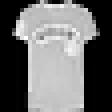
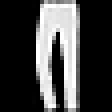
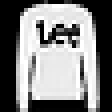
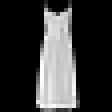
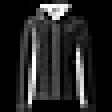
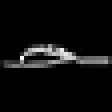
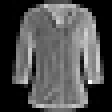
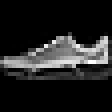
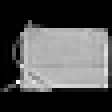
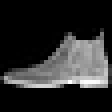
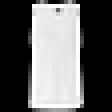
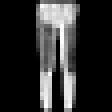
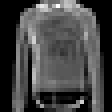
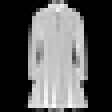
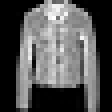
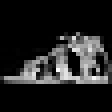
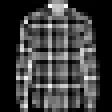
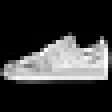
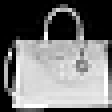
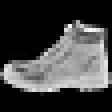
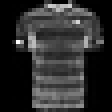
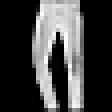
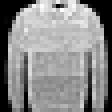
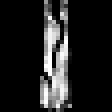
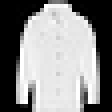
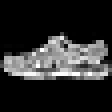
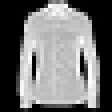
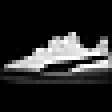
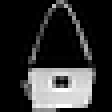
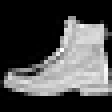

In [71]:
samples = get_correctly_predicted_samples(Xtest, ytest, model, 3)
colorview.(Gray, [samples[j][i][:,:,1,1] for i in 1:3, j in 0:9])

### Write sample files

In [119]:
@showprogress for cls in 0:9, i in 1:3
    write_image(samples[cls][i], model, "results/examples/fashion_mnist_$(i)_cls_$(cls)")
end